# Comparing different approaches to avoid double counting in LCA

In [2]:
import brightway2 as bw
import numpy as np
import matplotlib.pyplot as plt

In [3]:
bw.projects.set_current("test")
db = bw.Database("ecoinvent_remind_default_2030")

methods =  [
    ('ReCiPe Midpoint (H) V1.13', 'agricultural land occupation', 'ALOP'),
    ('ReCiPe Midpoint (H) V1.13', 'climate change', 'GWP100'),
    ('ReCiPe Midpoint (H) V1.13', 'fossil depletion', 'FDP'),
    ('ReCiPe Midpoint (H) V1.13', 'freshwater ecotoxicity', 'FETPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'freshwater eutrophication', 'FEP'),
    ('ReCiPe Midpoint (H) V1.13', 'human toxicity', 'HTPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'ionising radiation', 'IRP_HE'),
    ('ReCiPe Midpoint (H) V1.13', 'marine ecotoxicity', 'METPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'marine eutrophication', 'MEP'),
    ('ReCiPe Midpoint (H) V1.13', 'metal depletion', 'MDP'),
    ('ReCiPe Midpoint (H) V1.13', 'natural land transformation', 'NLTP'),
    ('ReCiPe Midpoint (H) V1.13', 'ozone depletion', 'ODPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'particulate matter formation', 'PMFP'),
    ('ReCiPe Midpoint (H) V1.13', 'photochemical oxidant formation', 'POFP'),
    ('ReCiPe Midpoint (H) V1.13', 'terrestrial acidification', 'TAP100'),
    ('ReCiPe Midpoint (H) V1.13', 'terrestrial ecotoxicity', 'TETPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'urban land occupation', 'ULOP'),
    ('ReCiPe Midpoint (H) V1.13', 'water depletion', 'WDP')
]

Find activities

In [4]:
car = None
steel = None
for act in db:
    if act["name"] == "transport, passenger car, medium size, diesel, EURO 4" and act["location"] == "RER":
        car = act
    if act["name"] == "market for reinforcing steel" and act["location"] == "GLO":
        steel = act


In [5]:
demand = {car: 1}

First, let's see the full impacts:

In [6]:
lca = bw.LCA(demand=demand)
lca.lci()
impacts_full = []
for m in methods:
    lca.switch_method(m)
    lca.lcia()
    impacts_full.append(lca.score)
    print("{}: {:f}".format(m[1], lca.score))

agricultural land occupation: 0.026356
climate change: 0.277589
fossil depletion: 0.096165
freshwater ecotoxicity: 0.018905
freshwater eutrophication: 0.000035
human toxicity: 0.078780
ionising radiation: 0.023851
marine ecotoxicity: 0.016445
marine eutrophication: 0.000149
metal depletion: 0.025927
natural land transformation: -0.000023
ozone depletion: 0.000000
particulate matter formation: 0.000454
photochemical oxidant formation: 0.001174
terrestrial acidification: 0.000959
terrestrial ecotoxicity: 0.000457
urban land occupation: 0.008957
water depletion: 0.002201


In [7]:
lca.supply_array[lca.product_dict[steel.key]]

0.007621901129510877

## Approach A

Subtracting direct emissions.

In [8]:
sbar = lca.supply_array
sbar[lca.product_dict[steel.key]] = 0

In [9]:
fbar = lca.technosphere_matrix * sbar

In [10]:
steel.key

('ecoinvent_remind_default_2030', '33754bdc65e8f50fa85abf6a65b61f5e')

In [11]:
demandA = {}
for k, idx in lca.product_dict.items():
    demandA[k] = fbar[idx]

In [12]:
impactsA  = []
lcaA = bw.LCA(demand=demandA)
lcaA.lci()

for m in methods:
    lcaA.switch_method(m)
    lcaA.lcia()
    impactsA.append(lcaA.score)
    print("{}: {:f}".format(m[1], lcaA.score))

agricultural land occupation: 0.026356
climate change: 0.277589
fossil depletion: 0.096165
freshwater ecotoxicity: 0.018905
freshwater eutrophication: 0.000035
human toxicity: 0.078780
ionising radiation: 0.023851
marine ecotoxicity: 0.016445
marine eutrophication: 0.000149
metal depletion: 0.025927
natural land transformation: -0.000023
ozone depletion: 0.000000
particulate matter formation: 0.000454
photochemical oxidant formation: 0.001174
terrestrial acidification: 0.000959
terrestrial ecotoxicity: 0.000457
urban land occupation: 0.008957
water depletion: 0.002201


## Approach B

Get the steel supplied in the solved inventory problem, do another LCIA with that steel supply as demand, then subtract impacts.

In [13]:
lca.lci(demand)

In [14]:
steel_demand = lca.supply_array[lca.product_dict[steel.key]]
demandB = {
    car: 1,
    steel: -steel_demand
}

In [15]:
impactsB  = []
lcaB = bw.LCA(demand=demandB)
lcaB.lci()

for m in methods:
    lcaB.switch_method(m)
    lcaB.lcia()
    impactsB.append(lcaB.score)
    print("{}: {:f}".format(m[1], lcaB.score))

agricultural land occupation: 0.025947
climate change: 0.264717
fossil depletion: 0.092704
freshwater ecotoxicity: 0.018335
freshwater eutrophication: 0.000029
human toxicity: 0.072726
ionising radiation: 0.022959
marine ecotoxicity: 0.015878
marine eutrophication: 0.000145
metal depletion: 0.018129
natural land transformation: -0.000022
ozone depletion: 0.000000
particulate matter formation: 0.000417
photochemical oxidant formation: 0.001109
terrestrial acidification: 0.000921
terrestrial ecotoxicity: 0.000453
urban land occupation: 0.008689
water depletion: 0.002042


In [16]:
lca.inventory

<2142x31544 sparse matrix of type '<class 'numpy.float64'>'
	with 296053 stored elements in Compressed Sparse Row format>

## Approach C

Remove the row (set to zero) in the technosphere matrix corresponding to steel, and then proceed with the LCIA.

Note: Here only one steel product is removed. Actually, we should remove all kinds of steel products.

In [17]:
lcaC = bw.LCA(demand=demand)
lcaC.lci()

In [18]:
i = lcaC.product_dict[steel.key]
lcaC.technosphere_matrix[i,:] = 0

c:\Users\davidba\.conda\envs\bw2\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Redo LCI (solving the linear system), check that technosphere change is not overwrittten.

In [19]:
lcaC.lci_calculation()

In [20]:
impactsC  = []

for m in methods:
    lcaC.switch_method(m)
    lcaC.lcia()
    impactsC.append(lcaC.score)
    print("{}: {:f}".format(m[1], lcaC.score))

agricultural land occupation: 0.025791
climate change: 0.259798
fossil depletion: 0.091382
freshwater ecotoxicity: 0.018117
freshwater eutrophication: 0.000027
human toxicity: 0.070413
ionising radiation: 0.022618
marine ecotoxicity: 0.015662
marine eutrophication: 0.000144
metal depletion: 0.015149
natural land transformation: -0.000021
ozone depletion: 0.000000
particulate matter formation: 0.000403
photochemical oxidant formation: 0.001084
terrestrial acidification: 0.000906
terrestrial ecotoxicity: 0.000451
urban land occupation: 0.008587
water depletion: 0.001981


## Compare results

In [21]:
import pandas as pd

In [22]:
data_array = np.array([impacts_full, impactsA, impactsB, impactsC]).T
df = pd.DataFrame(
    data=data_array, 
    index=[m[1] for m in methods], 
    columns=["full", "approach A", "approach B", "approach C"]
    )
df

,full,approach A,approach B,approach C
agricultural land occupation,2.635569e-02,2.635569e-02,2.594711e-02,2.579098e-02
climate change,2.775889e-01,2.775889e-01,2.647168e-01,2.597978e-01
fossil depletion,9.616501e-02,9.616501e-02,9.270444e-02,9.138203e-02
freshwater ecotoxicity,1.890489e-02,1.890489e-02,1.833517e-02,1.811746e-02
freshwater eutrophication,3.496055e-05,3.496055e-05,2.901637e-05,2.674487e-05
human toxicity,7.877962e-02,7.877962e-02,7.272617e-02,7.041291e-02
ionising radiation,2.385098e-02,2.385098e-02,2.295914e-02,2.261834e-02
marine ecotoxicity,1.644465e-02,1.644465e-02,1.587831e-02,1.566188e-02
marine eutrophication,1.485405e-04,1.485405e-04,1.451630e-04,1.438724e-04
metal depletion,2.592706e-02,2.592706e-02,1.812883e-02,1.514883e-02


In [23]:
df["rel diff A"] = (df["approach A"] - df["full"]) / df["full"]
df["rel diff B"] = (df["approach B"] - df["full"]) / df["full"]
df["rel diff C"] = (df["approach C"] - df["full"]) / df["full"]
df

,full,approach A,approach B,approach C,rel diff A,rel diff B,rel diff C
agricultural land occupation,2.635569e-02,2.635569e-02,2.594711e-02,2.579098e-02,3.949182e-16,-0.015502,-0.021426
climate change,2.775889e-01,2.775889e-01,2.647168e-01,2.597978e-01,0.000000e+00,-0.046371,-0.064091
fossil depletion,9.616501e-02,9.616501e-02,9.270444e-02,9.138203e-02,1.587435e-15,-0.035986,-0.049737
freshwater ecotoxicity,1.890489e-02,1.890489e-02,1.833517e-02,1.811746e-02,-3.670423e-16,-0.030136,-0.041652
freshwater eutrophication,3.496055e-05,3.496055e-05,2.901637e-05,2.674487e-05,-5.814780e-16,-0.170025,-0.234999
human toxicity,7.877962e-02,7.877962e-02,7.272617e-02,7.041291e-02,-1.761596e-16,-0.076840,-0.106204
ionising radiation,2.385098e-02,2.385098e-02,2.295914e-02,2.261834e-02,1.454635e-16,-0.037392,-0.051681
marine ecotoxicity,1.644465e-02,1.644465e-02,1.587831e-02,1.566188e-02,-8.439090e-16,-0.034439,-0.047600
marine eutrophication,1.485405e-04,1.485405e-04,1.451630e-04,1.438724e-04,3.649517e-16,-0.022738,-0.031427
metal depletion,2.592706e-02,2.592706e-02,1.812883e-02,1.514883e-02,0.000000e+00,-0.300775,-0.415714


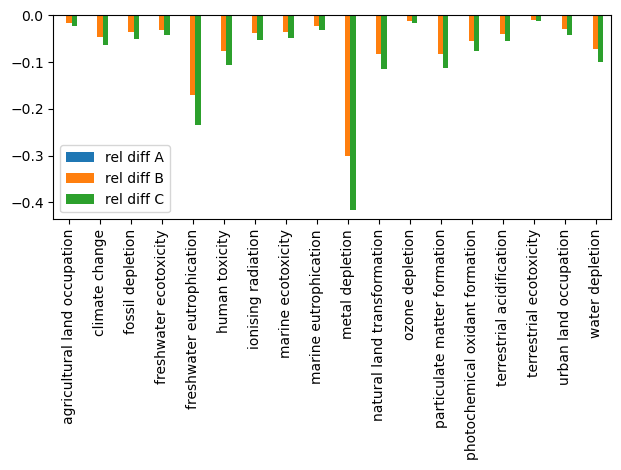

In [24]:
ax = df.plot.bar(y=["rel diff A", "rel diff B", "rel diff C"])
plt.tight_layout()
ax.figure.savefig("rel differences.png")

## Play around with top processes

In [ ]:
from bw2analyzer import ContributionAnalysis

In [ ]:
CA = ContributionAnalysis()
lca.method

('ReCiPe Midpoint (H) V1.13', 'water depletion', 'WDP')

In [ ]:
cum_score = 0
for p in CA.annotated_top_processes(lca):
    cum_score += p[0]
    print("{} \t {:f} \t {:f}".format(p[2], p[0]/lca.score, cum_score/lca.score))

'Farming and supply of rapeseed' (kilogram, EUR, None) 	 0.566920 	 0.566920
'electricity production, hydro, reservoir, alpine region' (kilowatt hour, NO, None) 	 0.022532 	 0.589452
'hot rolling, steel' (kilogram, RoW, None) 	 0.021487 	 0.610939
'hot rolling, steel' (kilogram, Europe without Austria, None) 	 0.011882 	 0.622821
'gravel production, crushed' (kilogram, RoW, None) 	 0.011173 	 0.633993
'electricity production, hydro, reservoir, non-alpine region' (kilowatt hour, CA-QC, None) 	 0.010914 	 0.644908
'sheet rolling, steel' (kilogram, RoW, None) 	 0.009086 	 0.653994
'air separation, cryogenic' (kilogram, RER, None) 	 0.008812 	 0.662807
'electricity production, hydro, reservoir, alpine region' (kilowatt hour, RoW, None) 	 0.008490 	 0.671296
'synthetic rubber production' (kilogram, RoW, None) 	 0.008201 	 0.679497
'polyol production' (kilogram, RoW, None) 	 0.008168 	 0.687665
'diesel production, petroleum refinery operation' (kilogram, Europe without Switzerland, None) 	 0

## Play around with graph traversal

In [ ]:
from bw2calc.graph_traversal import GraphTraversal

In [ ]:
Traverser = GraphTraversal()
upstream = Traverser.calculate(demand=demand, method=('ReCiPe Midpoint (H) V1.13', 'metal depletion', 'MDP'))

In [ ]:
upstream["edges"]

[{'to': -1,
  'from': 17804,
  'amount': 1,
  'exc_amount': 1,
  'impact': 0.025927055762462018},
 {'to': 17804,
  'from': 7795,
  'amount': 8.602154352280438e-06,
  'exc_amount': 8.602150955994148e-06,
  'impact': 0.0008081612787442103},
 {'to': 17804,
  'from': 16331,
  'amount': 0.0009113967640985765,
  'exc_amount': 0.0009113964042626321,
  'impact': 0.0007806491571112146},
 {'to': 17804,
  'from': 18963,
  'amount': 0.010666670763819181,
  'exc_amount': 0.01066666655242443,
  'impact': 0.023218776981269024},
 {'to': 17804,
  'from': 31494,
  'amount': 0.057447981419115,
  'exc_amount': 0.05744795873761177,
  'impact': 0.0010468601533613973},
 {'to': 18963,
  'from': 11496,
  'amount': 0.01066866310213532,
  'exc_amount': 1.0,
  'impact': 0.02322311382263763},
 {'to': 11496,
  'from': 2965,
  'amount': 0.0074128531358706165,
  'exc_amount': 0.6948249340057373,
  'impact': 0.016376793869165168},
 {'to': 11496,
  'from': 6409,
  'amount': 0.003255809648313764,
  'exc_amount': 0.30517

## Custom simple graph traversal

What's in technosphere?

In [ ]:
for exc in car.technosphere():
    print(type(exc.input))

<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>
<class 'bw2data.backends.peewee.proxies.Activity'>


In [ ]:
lca.characterized_inventory

<2142x2142 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>